<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/imageunderstanding'
!ls

/content/drive/MyDrive/imageunderstanding
ExampleSubmissionRandom.csv  PRED_RESULT.csv  Train_labels.csv
Load_data.ipynb		     Test.pkl	      Train.pkl


In [ ]:
%cd '/content/drive/MyDrive/551 A3'
!ls

/content/drive/MyDrive/551 A3
 ExampleSubmissionRandom.csv   Test.pkl		       Train_labels.csv
 LoadData.ipynb		      'Train_labels (1).csv'   Train.pkl


In [3]:
TRAIN_DATA_PATH = "Train.pkl"
TRAIN_LABEL_PATH = "Train_labels.csv"
TEST_DATA_PATH = "Test.pkl"
CSV_OUTPUT_PATH = "PRED_RESULT.csv"

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import pandas as pd

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Dataset Class / Data Loaders

In [7]:
IMG_SIZE = (200, 200)

In [14]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Resize(IMG_SIZE)  
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    # transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)
])

In [15]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [16]:
BATCH_SIZE = 256
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
# dataloader for all data
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Get loaders for train/val data

In [17]:
VAL_SPLIT = 0.15
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=train_indices)
val_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=val_indices)

# separate loaders for train and val data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Test Dataset / Loader

In [ ]:
class MyTestSet(Dataset):
  def __init__(self, img_file, transform=None):
    self.data = pickle.load( open(img_file, 'rb' ), encoding='bytes')
    self.transform = transform

  def __len__(self):
    # return self.data.shape[0]
    return len(self.data)

  def __getitem__(self, index):
    img = self.data[index].squeeze()
    img = Image.fromarray((img*255).astype('uint8'), mode='L')
    if self.transform is not None:
      img = self.transform(img)
    return img

In [ ]:
test_dataset = MyTestSet(TEST_DATA_PATH,transform=img_transform)
# dataloader for test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Visualize some data

torch.Size([256, 1, 200, 200])
torch.Size([256, 200, 200])


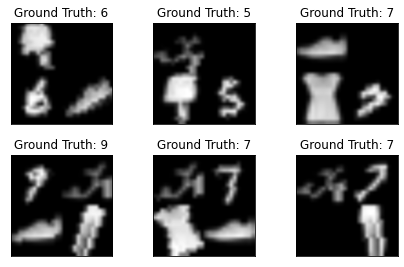

In [18]:
# Read a batch of data and their labels and display them
[imgs, labels] = (next(iter(train_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(imgs[50].cpu().numpy(),cmap='gray',interpolation="bicubic") #.transpose()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

torch.Size([256, 1, 28, 28])
torch.Size([256, 28, 28])


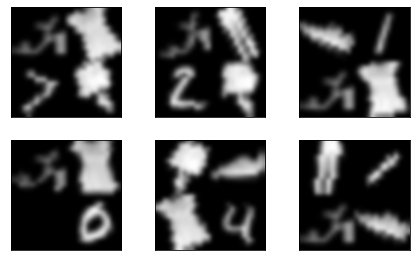

In [ ]:
# Read a batch of TEST data and display them
imgs = (next(iter(test_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(imgs[50].cpu().numpy(),cmap='gray',interpolation="bicubic") #.transpose()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.xticks([])
  plt.yticks([])

In [ ]:
# Here is a piece of code that reads data in batch.
# In each epoch all samples are read in batches using dataloader

num_epochs=2 # Feel free to change it
for epoch in range(num_epochs):
    for data in data_loader:
        [img,label] = data



## LeNet5

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [ ]:
ActFunc = {
    'Relu': nn.ReLU(True), 
    'Sig': nn.Sigmoid(),  # may vanishing gradient problems 
    'Tanh': nn.Tanh(), # may  vanishing gradient problems 
    'LeakyRelu': nn.LeakyReLU(), 
    'ELU': nn.ELU()
}

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, kernel_size=5,ActFunc=['Tanh']):
        super(LeNet5, self).__init__()
        # input 1*28*28
        self.conv1 = nn.Conv2d(1, 6, kernel_size,padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.conv3 = nn.Conv2d(16, 120, kernel_size)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # x = F.avg_pool2d(F.tanh(self.conv1(x)), kernel_size = (2,2),stride = 2) # 6 filters + avgpooling => 6*14*14
        # x = F.avg_pool2d(F.tanh(self.conv2(x)), kernel_size = (2,2),stride = 2) # 16 filters + avgpooling => 16*5*5
        x = F.avg_pool2d(torch.tanh(self.conv1(x)), kernel_size = (2,2),stride = 2) # 6 filters + avgpooling => 6*14*14
        x = F.avg_pool2d(torch.tanh(self.conv2(x)), kernel_size = (2,2),stride = 2) # 16 filters + avgpooling => 16*5*5
        x = torch.tanh(self.conv3(x)) # 120 filters => 120*1*1
        x = x.view(-1, 120) 
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        # x = (self.fc3(x) # output layer
        return F.softmax(x)

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

In [ ]:
model = LeNet5().to(DEVICE)
# optimizer = optim.SGD(tutor_model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(tutor_model.parameters(), lr=1, momentum=0.5)
optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters())

train_losses = []
train_counter = []
val_losses = []
val_counter = [i*len(train_loader.dataset) for i in range(3)]

### Train and test function, used many times

In [ ]:
def train(epoch, model, loader):
  model.train()
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    # print(data.shape)
    target = target.to(DEVICE)
    output = model(data)
    # print(output.shape)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D
    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #   epoch, batch_idx * len(data), len(loader.dataset),
      #   100. * batch_idx / len(loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(loader.dataset)))
      torch.save(model.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def val(model, loader):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = model(data)
      val_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(loader.dataset)
  val_losses.append(val_loss)
  print('Epoch: {}, Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    epoch, val_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)))

In [ ]:
len(data_loader.dataset)

60000

In [ ]:
len(train_loader.dataset)

51000

Train the network

In [ ]:
for epoch in range(1, 50):
  train(epoch, model, train_loader)
  val(model, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Test set: Avg. loss: -0.1144, Accuracy: 1030/9000 (11%)
Epoch: 2, Test set: Avg. loss: -0.1419, Accuracy: 1313/9000 (15%)
Epoch: 3, Test set: Avg. loss: -0.3981, Accuracy: 3693/9000 (41%)
Epoch: 4, Test set: Avg. loss: -0.5102, Accuracy: 4687/9000 (52%)
Epoch: 5, Test set: Avg. loss: -0.5721, Accuracy: 5260/9000 (58%)
Epoch: 6, Test set: Avg. loss: -0.6024, Accuracy: 5494/9000 (61%)
Epoch: 7, Test set: Avg. loss: -0.6347, Accuracy: 5799/9000 (64%)
Epoch: 8, Test set: Avg. loss: -0.6517, Accuracy: 5954/9000 (66%)
Epoch: 9, Test set: Avg. loss: -0.6684, Accuracy: 6088/9000 (68%)
Epoch: 10, Test set: Avg. loss: -0.6878, Accuracy: 6263/9000 (70%)
Epoch: 11, Test set: Avg. loss: -0.7229, Accuracy: 6581/9000 (73%)
Epoch: 12, Test set: Avg. loss: -0.7456, Accuracy: 6798/9000 (76%)
Epoch: 13, Test set: Avg. loss: -0.7578, Accuracy: 6877/9000 (76%)
Epoch: 14, Test set: Avg. loss: -0.7699, Accuracy: 6999/9000 (78%)
Epoch: 15, Test set: Avg. loss: -0.7712, Accuracy: 6989/9000 (78%)
Epoc

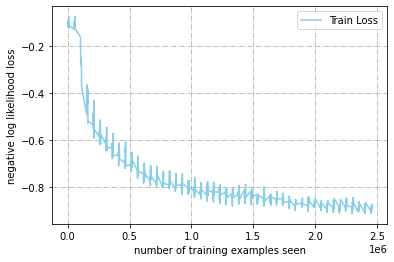

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='skyblue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.grid(linestyle='-.')

## Train on ALL data

In [ ]:
full_model = Tutor_model().to(DEVICE)
optimizer = optim.Adam(full_model.parameters())

In [ ]:
for epoch in range(1, 40):
  train(epoch, full_model, data_loader)
  val(full_model, val_loader)

## Make predictions on test data

In [ ]:
def predict(model):
  pred_test = []
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      data = data.to(DEVICE)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      for x in pred:
        pred_test.append(x.item())
  return pred_test

In [ ]:
pred_test = predict(full_model)
print(len(pred_test))
df_pred_test = pd.DataFrame({'id': range(10000), 'class': pred_test})
df_pred_test.to_csv(CSV_OUTPUT_PATH, index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Length 10000


## Manually check prediction results

torch.Size([256, 1, 28, 28])
torch.Size([256, 28, 28])


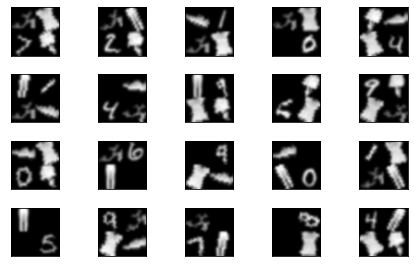

In [ ]:
# Read many TEST data and display them, compare with our prediction in CSV
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
imgs = (next(iter(test_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.xticks([])
  plt.yticks([])

## Deeper（doesn't work）

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(), # 26*26
      nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(), # 24*24
      # nn.MaxPool2d(2,2), # 13*13

      nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),  # 22*22
      nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),  # 20*20
      # nn.MaxPool2d(2,2),  # 6*6

      nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),  # 18*18
      nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),  # 16*16
      # nn.MaxPool2d(2,2),  # 2*2

      nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(), # 14*14
      nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),  # 12*12
      # nn.MaxPool2d(2,2),

      nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),  # 10*10
      nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),  # 8*8
      nn.MaxPool2d(2,2),  # 4*4

    )
    
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.25),
      # nn.Linear(4096, 256),
      nn.Linear(4096, 256),
      nn.ReLU(),

      nn.Dropout(0.5),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )
    
  def forward(self, x):
    f = self.model(x)
    y_pred = self.classifier(f)
    return y_pred

network = MyModel()
# summary(model, (3,256,256))

In [ ]:
optimizer = optim.Adam(network.parameters())

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)

    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      output = network(data)
      # this line is added to convert labels to LongTensor
      # target = target.type(torch.LongTensor)
      # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D

      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

In [ ]:
for epoch in range(1, 4):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.099955
Train Epoch: 1 [5120/60000 (11%)]	Loss: -0.097481
Train Epoch: 1 [10240/60000 (21%)]	Loss: -0.074219
Train Epoch: 1 [15360/60000 (32%)]	Loss: -0.109375
Train Epoch: 1 [20480/60000 (43%)]	Loss: -0.101562


KeyboardInterrupt: ignored

In [ ]:
print(torch.cuda.is_available())

True
